# K-fold cross validation

In [2]:
import numpy as np
from sklearn import cross_validation
from sklearn import datasets
from sklearn import svm

iris = datasets.load_iris()
# single train/test, 40% reserved for testing
X_train, X_test, y_train, y_test = cross_validation.train_test_split(iris.data, iris.target, test_size = 0.4, random_state = 0)
# SVC model for predicting iris classification using training data
clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
# measure it's performance with the test data
clf.score(X_test, y_test)

0.96666666666666667

In [3]:
scores = cross_validation.cross_val_score(clf, iris.data, iris.target, cv = 5)
print scores
print scores.mean()

[ 0.96666667  1.          0.96666667  0.96666667  1.        ]
0.98


In [4]:
clf = svm.SVC(kernel='poly', C=1).fit(X_train, y_train)
scores = cross_validation.cross_val_score(clf, iris.data, iris.target, cv=5)
print scores
print scores.mean()

[ 1.          1.          0.9         0.93333333  1.        ]
0.966666666667


In [5]:
# Polynomial kernel is overfitting, but we couldn't have noted it
# with only on train/test split:
clf = svm.SVC(kernel='poly', C=1).fit(X_train, y_train)
clf.score(X_test, y_test)

0.96666666666666667

In [6]:
# no difference in this case but in general it's better make cross validation

# Cleaning web log data

In [10]:
# Let's take a web access log and figure out the most viewed pages from it.
# let's set up a regex that lets us parse an apach access log line:
import re

format_pat = re.compile(
    r"(?P<host>[\d\.]+)\s"
    r"(?P<identity>\S*)\s"
    r"(?P<user>\S*)\s"
    r"\[(?P<time>.*?)\]\s"
    r'"(?P<request>.*?)"\s'
    r"(?P<status>\d+)\s"
    r"(?P<bytes>\S*)\s"
    r'"(?P<referer>.*?)"\s'
    r'"(?P<user_agent>.*?)"\s*'
)

logPath = "/Users/Andrew/python/notebooks/access_log.txt"


In [37]:
URLcounts = []
b_print = True

with open(logPath, "r") as f:
    for line in (l.strip() for l in f):
        match = format_pat.match(line)
        if match:
            access = match.groupdict()
            request = access['request']
            if b_print:
                print line
                print "\n"
                print access
                print "\n" + "request: " + request
                print request.split()
                (action, URL, protocol) = request.split()
                print "action: " + action
                print "URL: " + URL
                print "protocol: " + protocol
                break
            

66.249.75.159 - - [29/Nov/2015:03:50:05 +0000] "GET /robots.txt HTTP/1.1" 200 55 "-" "Mozilla/5.0 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)"


{'status': '200', 'bytes': '55', 'request': 'GET /robots.txt HTTP/1.1', 'host': '66.249.75.159', 'referer': '-', 'user': '-', 'time': '29/Nov/2015:03:50:05 +0000', 'identity': '-', 'user_agent': 'Mozilla/5.0 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)'}

request: GET /robots.txt HTTP/1.1
['GET', '/robots.txt', 'HTTP/1.1']
action: GET
URL: /robots.txt
protocol: HTTP/1.1


In [38]:
# let's extract urls and use a dictionary to count the number of times each appears

URLCounts = {}
with open(logPath, "r") as f:
    for line in (l.strip() for l in f):
        match = format_pat.match(line)
        if match:
            access = match.groupdict()
            request = access['request']
            (action, URL, protocol) = request.split()
            if URLCounts.has_key(URL):
                URLCounts[URL] = URLCounts[URL] + 1
            else:
                URLCounts[URL] = 1

results = sorted(URLCounts, key=lambda i: int(URLCounts[i]), reverse=True)

for result in results[:20]:
    print result + ": " + str(URLCounts[result])



ValueError: need more than 1 value to unpack

In [39]:
# let's figure out cuase of mistake

URLCounts = {}
with open(logPath, "r") as f:
    for line in (l.strip() for l in f):
        match = format_pat.match(line)
        if match:
            access = match.groupdict()
            request = access['request']
            fields = request.split()
            if len(fields) != 3:
                print fields

['_\\xb0ZP\\x07tR\\xe5']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


In [41]:
# let's modify script to take this into account

URLCounts = {}
with open(logPath, "r") as f:
    for line in (l.strip() for l in f):
        match = format_pat.match(line)
        if match:
            access = match.groupdict()
            request = access['request']
            fields = request.split()
            if (len(fields) == 3):
                URL = fields[1]
                if URLCounts.has_key(URL):
                    URLCounts[URL] = URLCounts[URL] + 1
                else:
                    URLCounts[URL] = 1

results = sorted(URLCounts, key=lambda i: int(URLCounts[i]), reverse=True)

for result in results[:20]:
    print result + ": " + str(URLCounts[result])


/xmlrpc.php: 68494
/wp-login.php: 1923
/: 440
/blog/: 138
/robots.txt: 123
/sitemap_index.xml: 118
/post-sitemap.xml: 118
/category-sitemap.xml: 117
/page-sitemap.xml: 117
/orlando-headlines/: 95
/san-jose-headlines/: 85
http://51.254.206.142/httptest.php: 81
/comics-2/: 76
/travel/: 74
/entertainment/: 72
/world/: 70
/business/: 70
/weather/: 70
/national/: 70
/national-headlines/: 70


In [43]:
# it's seems that website is under attack: frequent requests of
# xmlrpc.php and wp-login.php and corresponding requests are POST (execute) not GET type
# let's filter POST requests

URLCounts = {}
with open(logPath, "r") as f:
    for line in (l.strip() for l in f):
        match = format_pat.match(line)
        if match:
            access = match.groupdict()
            request = access['request']
            fields = request.split()
            if (len(fields) == 3):
                (action, URL, protocol) = fields
                if (action == 'GET'):
                    if URLCounts.has_key(URL):
                        URLCounts[URL] = URLCounts[URL] + 1
                    else:
                        URLCounts[URL] = 1

results = sorted(URLCounts, key=lambda i: int(URLCounts[i]), reverse=True)

for result in results[:20]:
    print result + ": " + str(URLCounts[result])

# it's strange that blog is highly requested (a few posts)
# let's examine 

/: 434
/blog/: 138
/robots.txt: 123
/sitemap_index.xml: 118
/post-sitemap.xml: 118
/category-sitemap.xml: 117
/page-sitemap.xml: 117
/orlando-headlines/: 95
/san-jose-headlines/: 85
http://51.254.206.142/httptest.php: 81
/comics-2/: 76
/travel/: 74
/entertainment/: 72
/world/: 70
/business/: 70
/weather/: 70
/national/: 70
/national-headlines/: 70
/defense-sticking-head-sand/: 69
/about/: 69


In [51]:
URLCounts = {}
b = True
with open(logPath, "r") as f:
    for line in (l.strip() for l in f):
        match = format_pat.match(line)
        if match:
            access = match.groupdict()
            request = access['request']
            fields = request.split()
            if (len(fields) == 3):
                (action, URL, protocol) = fields
                if (action == 'GET'):
                    if URL == "/blog/" and b:
                        print access
                    if URLCounts.has_key(URL):
                        URLCounts[URL] = URLCounts[URL] + 1
                    else:
                        URLCounts[URL] = 1

results = sorted(URLCounts, key=lambda i: int(URLCounts[i]), reverse=True)

#for result in results[:20]:
    #print result + ": " + str(URLCounts[result])
    
# a lot of reauests do not contain user_agent; that means that
# may be not real user but scrpper

{'status': '200', 'bytes': '8083', 'request': 'GET /blog/ HTTP/1.1', 'host': '66.249.75.168', 'referer': '-', 'user': '-', 'time': '29/Nov/2015:03:50:06 +0000', 'identity': '-', 'user_agent': 'Mozilla/5.0 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)'}
{'status': '200', 'bytes': '31746', 'request': 'GET /blog/ HTTP/1.0', 'host': '54.165.199.171', 'referer': '-', 'user': '-', 'time': '29/Nov/2015:04:32:27 +0000', 'identity': '-', 'user_agent': '-'}
{'status': '200', 'bytes': '31784', 'request': 'GET /blog/ HTTP/1.0', 'host': '54.165.199.171', 'referer': '-', 'user': '-', 'time': '29/Nov/2015:05:32:23 +0000', 'identity': '-', 'user_agent': '-'}
{'status': '200', 'bytes': '31784', 'request': 'GET /blog/ HTTP/1.0', 'host': '54.165.199.171', 'referer': '-', 'user': '-', 'time': '29/Nov/2015:06:32:21 +0000', 'identity': '-', 'user_agent': '-'}
{'status': '200', 'bytes': '31771', 'request': 'GET /blog/ HTTP/1.0', 'host': '54.165.199.171', 'referer': '-', 'user': '-', 'time': '2

In [52]:
# let's print user_agents

userAgent = {}
with open(logPath, "r") as f:
    for line in (l.strip() for l in f):
        match = format_pat.match(line)
        if match:
            access = match.groupdict()
            agent = access['user_agent']
            if userAgent.has_key(agent):
                userAgent[agent] = userAgent[agent] + 1
            else:
                userAgent[agent] = 1

results = sorted(userAgent, key=lambda i: int(userAgent[i]), reverse=True)

for result in results:
    print result + ": " + str(userAgent[result])

Mozilla/4.0 (compatible: MSIE 7.0; Windows NT 6.0): 68484
-: 4035
Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.0): 1724
W3 Total Cache/0.9.4.1: 468
Mozilla/5.0 (compatible; Baiduspider/2.0; +http://www.baidu.com/search/spider.html): 278
Mozilla/5.0 (compatible; Googlebot/2.1; +http://www.google.com/bot.html): 248
Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/46.0.2490.86 Safari/537.36: 158
Mozilla/5.0 (Windows NT 6.1; WOW64; rv:40.0) Gecko/20100101 Firefox/40.0: 144
Mozilla/5.0 (iPad; CPU OS 8_4 like Mac OS X) AppleWebKit/600.1.4 (KHTML, like Gecko) Version/8.0 Mobile/12H143 Safari/600.1.4: 120
Mozilla/5.0 (Linux; Android 5.1.1; SM-G900T Build/LMY47X) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/46.0.2490.76 Mobile Safari/537.36: 47
Mozilla/5.0 (compatible; bingbot/2.0; +http://www.bing.com/bingbot.htm): 43
Mozilla/5.0 (compatible; MJ12bot/v1.4.5; http://www.majestic12.co.uk/bot.php?+): 41
Opera/9.80 (Windows NT 6.0) Presto/2.12.388 Version/12.1

In [54]:
# let's filter what we can with 'spide', 'bot', etc.

URLCounts = {}
with open(logPath, "r") as f:
    for line in (l.strip() for l in f):
        match = format_pat.match(line)
        if match:
            access = match.groupdict()
            agent = access['user_agent']
            if (not('bot' in agent or 'spider' in agent or
                   'Bot' in agent or 'Spider' in agent or
                   'W3 Total Cashe' in agent or agent == '-')):
                request = access['request']
                fields = request.split()
                if (len(fields) == 3):
                    (action, URL, protocol) = fields
                    if (action == 'GET'):
                        if URLCounts.has_key(URL):
                            URLCounts[URL] = URLCounts[URL] + 1
                        else:
                            URLCounts[URL] = 1

results = sorted(URLCounts, key=lambda i: int(URLCounts[i]), reverse=True)

for result in results:
    print result + ": " + str(URLCounts[result])



/page-sitemap.xml: 117
/sitemap_index.xml: 117
/category-sitemap.xml: 117
/post-sitemap.xml: 117
/: 77
/orlando-headlines/: 36
/?page_id=34248: 28
/wp-content/cache/minify/000000/M9bPKixNLarUy00szs8D0Zl5AA.js: 27
/wp-content/cache/minify/000000/lY7dDoIwDIVfiG0KxkfxfnbdKO4HuxICTy-it8Zw15PzfSftzPCckJem-x4qUWArqBPl5mygZLEgyhdOaoxToGyGaiALiOfUnIz0qDLOdSZGE-nOlpc3kopDzrSyavVVt_veb5qSDVhjsQ6dHh_B_eE_z2pYIGJ7iBWKeEio_eT9UQe4xHhDll27mGRryVu_pRc.js: 27
/wp-content/cache/minify/000000/M9AvyUjVzUstLy7PLErVz8lMKkosqtTPKtYvTi7KLCgpBgA.js: 27
/wp-content/cache/minify/000000/fY45DoAwDAQ_FMvkRQgFA5ZyWLajiN9zNHR0O83MRkyt-pIctqYFJPedKyYzfHg2PzOFiENAzaD07AxcpKmTolORvDjZt8KEfhBUGjZYCf8Fb0fvA1TXCw.css: 25
/?author=1: 21
/wp-content/cache/minify/000000/hcrRCYAwDAXAhXyEjiQ1YKAh4SVSx3cE7_uG7ASr4M9qg3kGWyk1adklK84LHtRj_My6Y0Pfqcz-AA.js: 20
/wp-content/uploads/2014/11/nhn1.png: 19
/wp-includes/js/wp-emoji-release.min.js?ver=4.3.1: 17
/wp-content/cache/minify/000000/BcGBCQAgCATAiUSaKYSERPk3avzuht4SkBJnt4tHJdqgnP

In [55]:
# let's delete all urls without / at the end

URLCounts = {}
with open(logPath, "r") as f:
    for line in (l.strip() for l in f):
        match = format_pat.match(line)
        if match:
            access = match.groupdict()
            agent = access['user_agent']
            if (not('bot' in agent or 'spider' in agent or
                   'Bot' in agent or 'Spider' in agent or
                   'W3 Total Cashe' in agent or agent == '-')):
                request = access['request']
                fields = request.split()
                if (len(fields) == 3):
                    (action, URL, protocol) = fields
                    if (URL.endswith("/")):
                        if (action == 'GET'):
                            if URLCounts.has_key(URL):
                                URLCounts[URL] = URLCounts[URL] + 1
                            else:
                                URLCounts[URL] = 1

results = sorted(URLCounts, key=lambda i: int(URLCounts[i]), reverse=True)

for result in results:
    print result + ": " + str(URLCounts[result])

/: 77
/orlando-headlines/: 36
/world/: 12
/comics-2/: 12
/weather/: 4
/about/: 4
/australia/: 4
/national-headlines/: 3
/sample-page/feed/: 2
/feed/: 2
/technology/: 2
/science/: 2
/entertainment/: 1
/san-jose-headlines/: 1
/business/: 1
/travel/feed/: 1


# Dealing with outliers

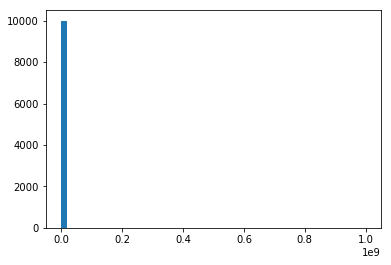

In [56]:
import numpy as np
import matplotlib.pyplot as plt

incomes = np.random.normal(27000, 15000, 10000)
incomes = np.append(incomes, [1000000000])

plt.hist(incomes, 50)
plt.show()


In [57]:
incomes.mean()

127028.81666824019

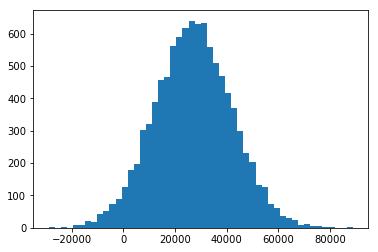

In [58]:
# mean not very helpful to understand data: 
# it differs greatly from real mean 27000, but this is a hint about something
# anormal or outliers
# it's not correct just to cut out data at specific point; better way to
# identify outliers several std from the mean

def reject_outliers(data):
    u = np.median(data) # using median in case of such big outliers more correct
    s = np.std(data)
    filtered = [e for e in data if (u - 2 * s < e < u + 2 * s)]
    return filtered

filtered = reject_outliers(incomes)

plt.hist(filtered, 50)
plt.show()

In [61]:
import json
from urllib import urlopen
url = "https://www.youtube.com/feed/trending"
response = urlopen(url)
contents = response.read()
text = contents.decode('utf8')
data = json.loads(text)
print data
#for video in data['feed']['entry'][0:6]:
#    print(video['title']['$t'])

ValueError: No JSON object could be decoded